In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [2]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
l2fc.all = read.csv("../data/l2fc_table_all.csv")
l2fc.filtered = read.csv("../data/l2fc_table.csv")

Joining by: "OTU"


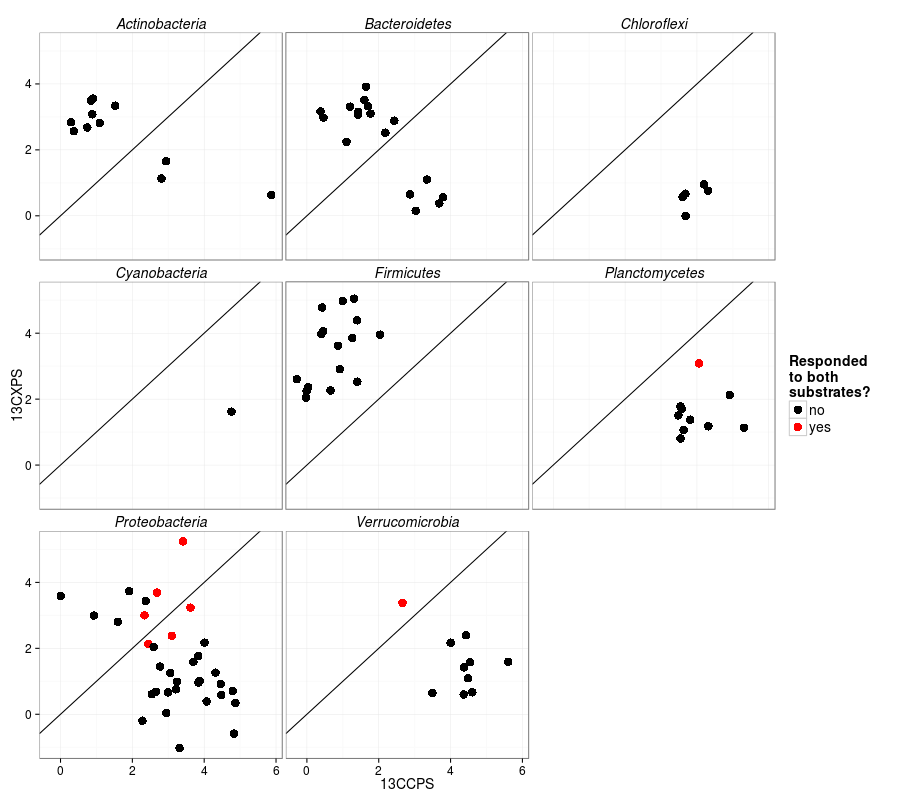

In [9]:
%%R -w 900 -h 800
FDR = 0.10

d1 = l2fc.filtered %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) %>%
    mutate(rspnse.t = ifelse(rspnse == 2, "yes", "no"))

rspndrs = unique(d$OTU)

d2 = l2fc.all %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc)

d = left_join(d1, d2)

p = ggplot(d, aes(x = `13CCPS`, y = `13CXPS`, color = rspnse.t))

p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 4)

p = p + geom_abline(intercept = 0)

p = p + theme_bw()

p = p + labs(color = "Responded\nto both\nsubstrates?")

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p

In [36]:
%%R
FDR = 0.10

df.rspndrs = read.csv("../data/l2fc_table.csv") %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose", "Xylose"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13CCPS", "13CXPS")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [104 x 2]

        OTU    rspnse
1   OTU.100 Cellulose
2  OTU.1023 Cellulose
3  OTU.1040    Xylose
4  OTU.1065 Cellulose
5  OTU.1069    Xylose
6   OTU.107    Xylose
7  OTU.1087 Cellulose
8  OTU.1094 Cellulose
9    OTU.11      Both
10  OTU.114 Cellulose
..      ...       ...


In [37]:
%%R
l2fc.all %>%
    left_join(df.rspndrs) %>%
    group_by(Rank2) %>%
    mutate(phylum.rspnse = ifelse(sum(!is.na(rspnse)) > 0, "rspndr", "none")) %>%
    filter(phylum.rspnse == "rspndr") %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc) %>%
    left_join(df.rspndrs)

Joining by: "OTU"
Joining by: "OTU"
Source: local data frame [4,971 x 6]

        OTU          Rank2               Rank3      13CCPS    13CXPS    rspnse
1     OTU.1 Actinobacteria       Micrococcales -0.43726940 1.4213889        NA
2    OTU.10 Proteobacteria Alphaproteobacteria -0.58470316 0.6135780        NA
3   OTU.100 Proteobacteria Gammaproteobacteria  2.66270283 0.6857770 Cellulose
4  OTU.1000 Proteobacteria Deltaproteobacteria -0.61896634 0.4540365        NA
5  OTU.1001 Planctomycetes    Planctomycetacia -0.09790673 0.3125433        NA
6  OTU.1004 Proteobacteria Deltaproteobacteria  0.87048753 0.6401006        NA
7  OTU.1005    Chloroflexi        Anaerolineae  1.39676440 0.1703519        NA
8  OTU.1006 Planctomycetes        Pla4_lineage  1.29003736 1.7427004        NA
9  OTU.1007 Actinobacteria          Frankiales  1.42273649 0.6615457        NA
10 OTU.1008 Actinobacteria           MB-A2-108  1.48659547 0.6152795        NA
..      ...            ...                 ...         ..

Joining by: "OTU"
Joining by: "OTU"


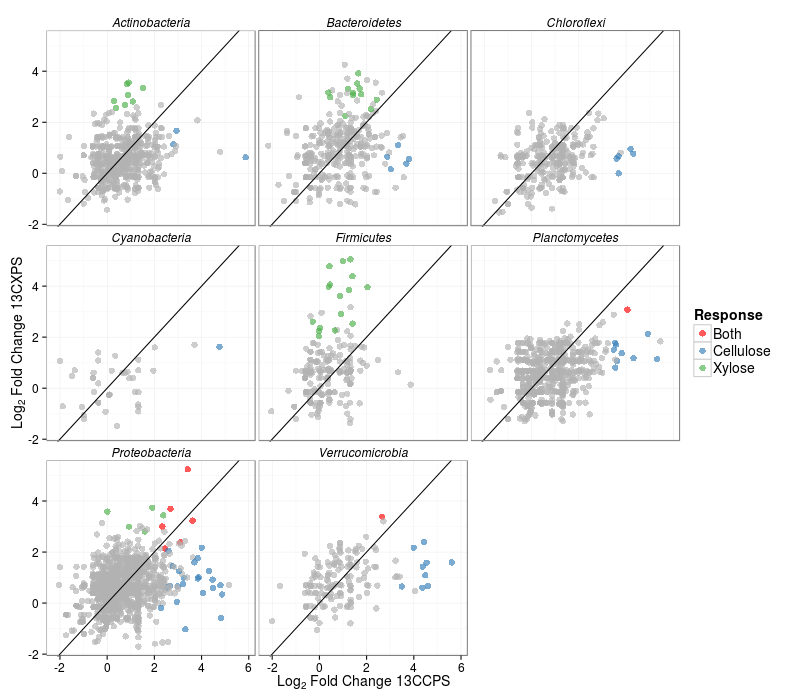

In [40]:
%%R -w 800 -h 700
FDR = 0.10

#d1 = l2fc.filtered %>%
#    group_by(OTU, Treatment, Rank2) %>%
#    summarize(minP = min(padj)) %>%
#    group_by(OTU) %>%
#    summarize(rspnse = sum(minP <= FDR)) %>%
#    mutate(rspnse.t = ifelse(rspnse == 2, "both", ifelse( rspnse == 1, "one", "none")))
colours = c("red", "#377eb8", "#4daf4a")

d = l2fc.all %>%
    left_join(df.rspndrs) %>%
    group_by(Rank2) %>%
    mutate(phylum.rspnse = ifelse(sum(!is.na(rspnse)) > 0, "rspndr", "none")) %>%
    filter(phylum.rspnse == "rspndr") %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc) %>%
    left_join(df.rspndrs)

p = ggplot(d, aes(x = `13CCPS`, y = `13CXPS`, color = rspnse))

#p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 3, alpha = 0.65)

p = p + geom_abline(intercept = 0)

p = p + scale_color_manual(values = colours, na.value = "grey70")

p = p + theme_bw()

p = p + labs(color = "Response")

p = p + labs(y = expression(paste("", Log[2]," Fold Change"," 13CXPS",sep="")), 
             x = expression(paste("", Log[2]," Fold Change"," 13CCPS",sep="")))


p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p

In [41]:
%%R
ggsave("figs/generalist_specialist.pdf", p, h = 9, w = 11)

In [8]:
FileLink("figs/generalist_specialist.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/generalist_specialist.pdf